<a href="https://colab.research.google.com/github/Indrajeet71/tensorflow/blob/main/Resnet_152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [2]:
!gdown --id 1Ilfihfk2QxOcgikb2ihNO1YakXUCIPMe

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1Ilfihfk2QxOcgikb2ihNO1YakXUCIPMe
From (redirected): https://drive.google.com/uc?id=1Ilfihfk2QxOcgikb2ihNO1YakXUCIPMe&confirm=t&uuid=7d046323-9b73-47e4-b8d4-29750d6a59ae
To: /content/increased data.zip
100% 1.38G/1.38G [00:23<00:00, 57.7MB/s]


In [4]:
from zipfile import ZipFile

file_name = "/content/increased data.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [5]:
!pip install fvcore=='0.1.dev200114'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.dev200114-py3-none-any.whl size=30357 sha256=996601c17b9a4251c657efacdba99a35ea75124a13a51d745ea3a01306d3f97d
  Stored in directory: /root/.cache/pip/wheels/d2/f7/63/b336a1e4b1036e509fcf786c401ec76b52bcb85fa46ab1584b
Successfully built fvcore


In [8]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import seaborn as sns
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

import itertools
import logging
from typing import Any, Dict, Iterable, List, Optional, Tuple, Type
import tqdm

from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import fvcore
from fvcore.nn.precise_bn import update_bn_stats

import argparse
import sys
import datetime
import math
import json
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mp_image
from sklearn.metrics import confusion_matrix
import seaborn as sns

from PIL import Image
import torch.distributed as dist
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms
from torchvision import models as torchvision_models
torch.cuda.empty_cache()

DIR = "data"
DIR_TRAIN = "/content/data/train"
DIR_TEST = "/content/data/test"

In [12]:
classes = os.listdir(DIR_TRAIN)
print("Total Classes: ",len(classes))

#Counting total train, valid & test images

train_count = 0
valid_count = 0
test_count = 0

classes_df = []
for _class in classes:
    class_dict = {}
    train_count += len(os.listdir("/content/data/train"))
    test_count += len(os.listdir("/content/data/test"))
    #print(f'Class {_class}: train amount {train_count}, test amount {test_count} ')
    class_dict.update({'Class': _class, 'Train': len(os.listdir("/content/data/train")), 'Test': len(os.listdir("/content/data/test")) })
    classes_df.append(class_dict)

print("Total train images: ",train_count)
print("Total test images: ",test_count)
print(pd.DataFrame(classes_df))

Total Classes:  10
Total train images:  100
Total test images:  100
                                               Class  Train  Test
0                                      Eczema Photos     10    10
1  Tinea Ringworm Candidiasis and other Fungal In...     10    10
2                            Acne and Rosacea Photos     10    10
3                Melanoma Skin Cancer Nevi and Moles     10    10
4                 Nail Fungus and other Nail Disease     10    10
5  Psoriasis pictures Lichen Planus and related d...     10    10
6  Actinic Keratosis Basal Cell Carcinoma and oth...     10    10
7                                   Systemic Disease     10    10
8       Seborrheic Keratoses and other Benign Tumors     10    10
9         Warts Molluscum and other Viral Infections     10    10


In [13]:
train_imgs = []
test_imgs = []

for _class in classes:
    
    for img in os.listdir("/content/data/train"):
        train_imgs.append("/content/data/train" + "/" + img)
    
    for img in os.listdir("/content/data/test"):
        test_imgs.append("/content/data/test" + "/" + img)

class_to_int = {classes[i] : i for i in range(len(classes))}

In [14]:
class_to_int

{'Eczema Photos': 0,
 'Tinea Ringworm Candidiasis and other Fungal Infections': 1,
 'Acne and Rosacea Photos': 2,
 'Melanoma Skin Cancer Nevi and Moles': 3,
 'Nail Fungus and other Nail Disease': 4,
 'Psoriasis pictures Lichen Planus and related diseases': 5,
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 6,
 'Systemic Disease': 7,
 'Seborrheic Keratoses and other Benign Tumors': 8,
 'Warts Molluscum and other Viral Infections': 9}

In [15]:
int_to_class =dict(map(reversed, class_to_int.items()))
int_to_class[9]

'Warts Molluscum and other Viral Infections'

In [17]:
train_dataset = ImageFolder(root = "/content/data/train", transform=transforms.Compose([
    transforms.RandomRotation([-8,+8]),                                           # if augmentation
    transforms.ColorJitter(brightness=0, contrast=0.4, saturation=0, hue=0),      # if augmentation
    transforms.RandomHorizontalFlip(),                                            # if augmentation
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))
test_dataset = ImageFolder(root = "/content/data/test", transform=transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

In [18]:
test_size = int(0.5 * len(test_dataset))
valid_size = len(test_dataset) - test_size
valid_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [valid_size, test_size])

In [19]:
dataloaders_dict = {}
dataloaders_dict['train'] = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
dataloaders_dict['val'] = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2, drop_last=False)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, drop_last=False)

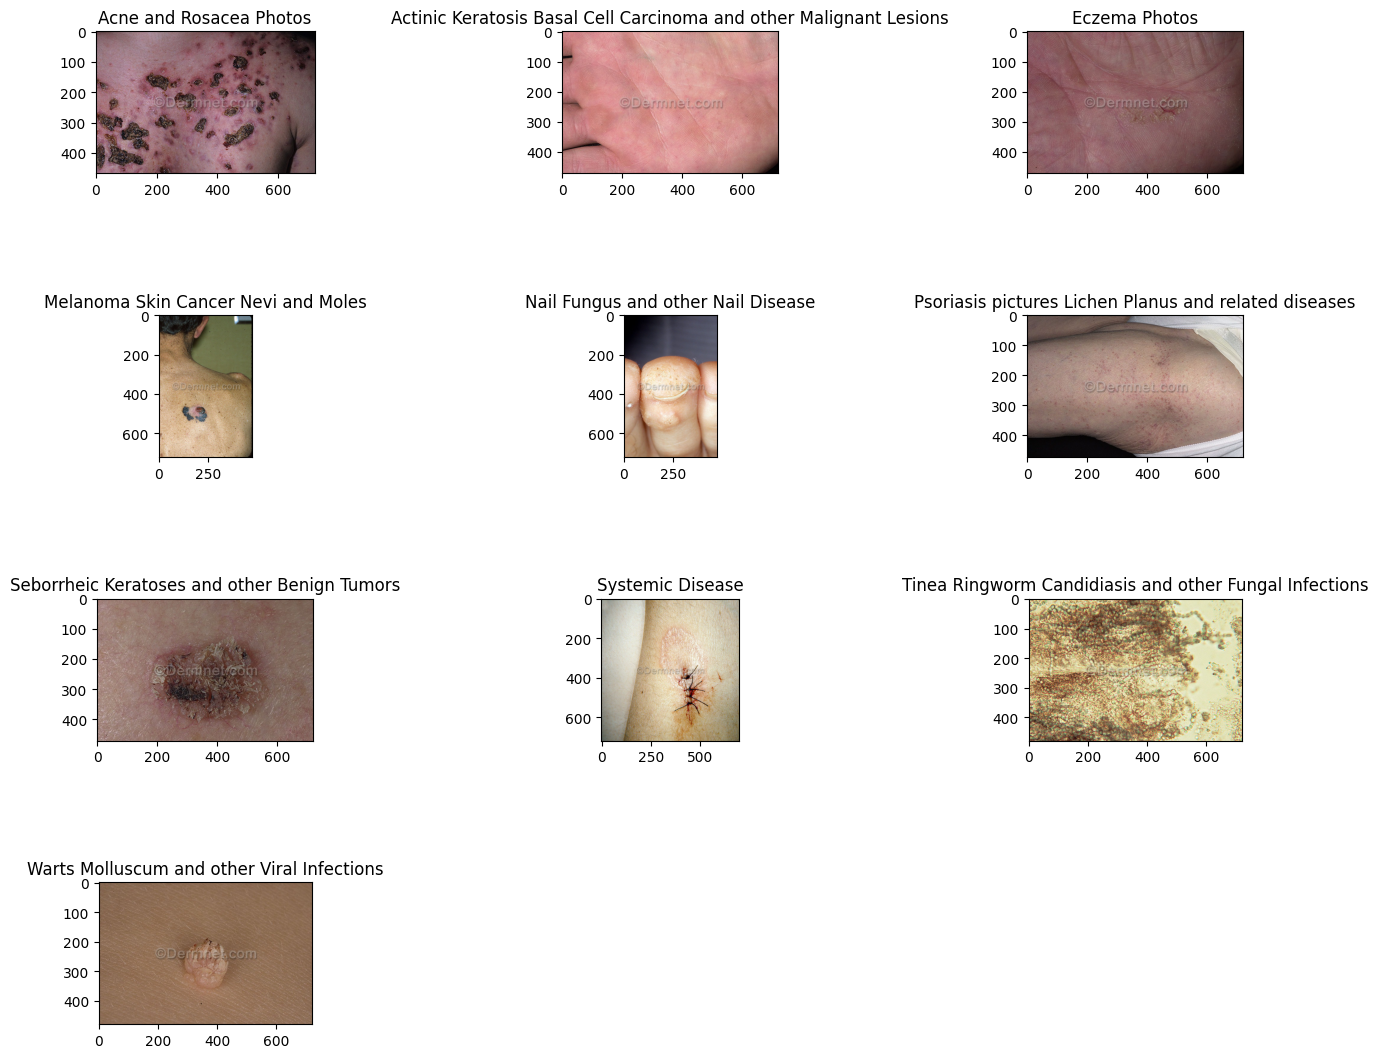

In [20]:
# Set up the folder where the images are
src_folder = '/content/data/train'

# Set up a figure of an appropriate size
fig = plt.figure(figsize=(15, 35))

# loop through the subfolders
for root, folders, filenames in os.walk(src_folder):
    image_num = 0
    num_folders = len(folders)
    for folder in sorted(folders):
        # Keep an incrementing count of each image
        image_num +=1
        # Find the image file in the folder
        file_name = os.listdir(os.path.join(root,folder))[8]
        # Get the full path from the root folder
        file_path = os.path.join(root,folder, file_name)
        # Open the file using the matplotlib.image library
        image = mp_image.imread(file_path)
        # Add the image to the figure (which will have a row for each folder, each containing 3 column for the image)
        a = fig.add_subplot(num_folders, 3, image_num)
        # Add the image to the plot
        image_plot = plt.imshow(image)
        # Add a caption with the folder name
        a.set_title(folder)
        
# Adjust vertical space
fig.subplots_adjust(hspace=1, wspace=1)
        
# Show the plot
plt.show()

In [21]:
# Number of classes in the dataset
num_classes = 10

# Batch size for training 
batch_size = 32

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True
input_size = 224

In [ ]:
# def train_model(model, dataloaders, criterion, optimizer, num_epochs):
#     since = time.time()

#     val_acc_history = []

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0


#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:               
#                 model.eval()   # Set model to evaluate mode
#                 #update_bn_stats(model=model, data_loader=dataloaders[phase])  # if update_bn_stats
                
#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     # Get model outputs and calculate loss
#                     # Special case for inception because in training it has an auxiliary output. In train
#                     #   mode we calculate the loss by summing the final output and the auxiliary output
#                     #   but in testing we only consider the final output.
                    
#                     outputs = model(inputs)
#                     loss = criterion(outputs, labels)

#                     _, preds = torch.max(outputs, 1)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                       # statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / len(dataloaders[phase].dataset)
#             epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

#                # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
#             if phase == 'val':
#                 val_acc_history.append(epoch_acc)

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))
   
#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model, val_acc_history

In [23]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:               
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    # Plot loss curves
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train')
    plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.show()
    
    # Plot accuracy curves
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_acc_history, label='Train')
    plt.plot(range(1, num_epochs + 1), val_acc_history, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')
    plt.show()

    return model, train_acc_history, val_acc_history




In [24]:
def test_model(model, dl, normalize=True):
  model.eval()
  true_labels = []
  predictions = []
  total = 0
  num_correct = 0
  with torch.no_grad():
      for images, labels in dl:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          predicted = torch.argmax(outputs.data,-1)        
          true_labels.append(labels.cpu().numpy())
          predictions.append(predicted.cpu().numpy())
          total += labels.size(0)
          num_correct += (predicted == labels).sum()
      print(f"Test Accuracy of the model: {float(num_correct)/float(total)*100:.2f}")    
      true_labels = np.hstack(true_labels)
      predictions = np.hstack(predictions)
      
  return true_labels, predictions

In [25]:
def test(model, dl, x, y, normalize=True):
  model.eval()
  true_labels = []
  predictions = []
  images_list = []

  with torch.no_grad():
      for images, labels in dl:
          images_list.append(images.cpu().numpy())
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          predicted = torch.argmax(outputs.data,-1)        
          true_labels.append(labels.cpu().numpy())
          predictions.append(predicted.cpu().numpy())
    
  for n in range(60):
    for i in range(32):
      if (true_labels[n][i] == x)  & (predictions[n][i] == y):
        #inv_tensor = inv_normalize(image_list[n][i]])
        plt.imshow(np.transpose(images_list[n][i], (1, 2, 0)))
        plt.show()

In [26]:
num_epochs = 60 

model = models.resnet152(pretrained=True)
model.fc = nn.Linear(2048, 23, bias=True)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 80.7MB/s]


Epoch 0/59
----------
train Loss: 1.5011 Acc: 0.4927
val Loss: 1.1990 Acc: 0.5861

Epoch 1/59
----------
train Loss: 1.1081 Acc: 0.6205
val Loss: 0.9723 Acc: 0.6763

Epoch 2/59
----------
train Loss: 0.8557 Acc: 0.7061
val Loss: 0.9481 Acc: 0.6945

Epoch 3/59
----------
train Loss: 0.6913 Acc: 0.7626
val Loss: 0.8310 Acc: 0.7411

Epoch 4/59
----------
train Loss: 0.5707 Acc: 0.8051
val Loss: 0.8358 Acc: 0.7396

Epoch 5/59
----------
train Loss: 0.4318 Acc: 0.8543
val Loss: 0.7596 Acc: 0.7832

Epoch 6/59
----------
train Loss: 0.3670 Acc: 0.8760
val Loss: 0.8201 Acc: 0.7573

Epoch 7/59
----------
train Loss: 0.3132 Acc: 0.8923
val Loss: 0.8666 Acc: 0.7761

Epoch 8/59
----------
train Loss: 0.2784 Acc: 0.9065
val Loss: 0.7663 Acc: 0.8014

Epoch 9/59
----------
train Loss: 0.2474 Acc: 0.9138
val Loss: 0.8062 Acc: 0.7918

Epoch 10/59
----------
train Loss: 0.2035 Acc: 0.9323
val Loss: 0.7872 Acc: 0.8040

Epoch 11/59
----------
train Loss: 0.2069 Acc: 0.9295
val Loss: 0.8436 Acc: 0.7877

Ep

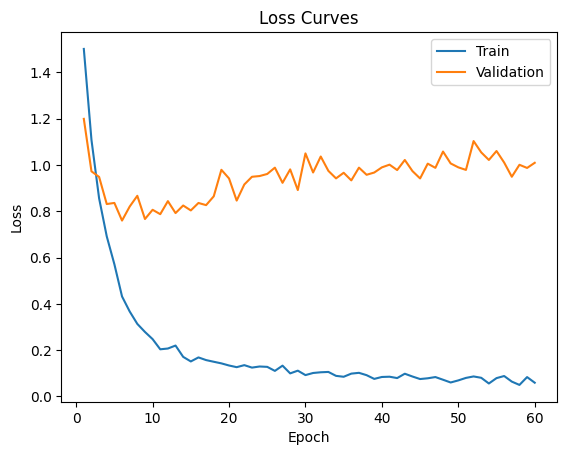

TypeError: ignored

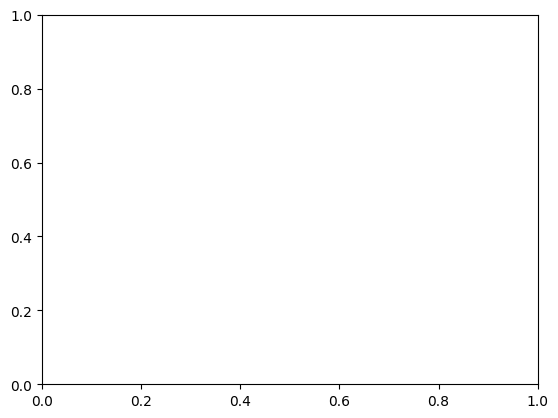

In [27]:
# Train and evaluate
model, train_acc, val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

In [28]:
torch.save(model.state_dict(), 'Resnet150pretrained_60epoch_v3_8')

In [29]:
import os

# save the state dictionary
torch.save(model.state_dict(), 'Resnet150pretrained_60epoch_v3_8')

# check if the file exists
if os.path.exists('Resnet150pretrained_60epoch_v3_8'):
    print('File saved successfully.')
    print('File path:', os.path.abspath('Resnet150pretrained_50epoch_v3_8'))
else:
    print('File not saved.')

File saved successfully.
File path: /content/Resnet150pretrained_50epoch_v3_8


In [30]:
model.load_state_dict(torch.load('Resnet150pretrained_60epoch_v3_8'))

<All keys matched successfully>

Test Accuracy of the model: 81.91


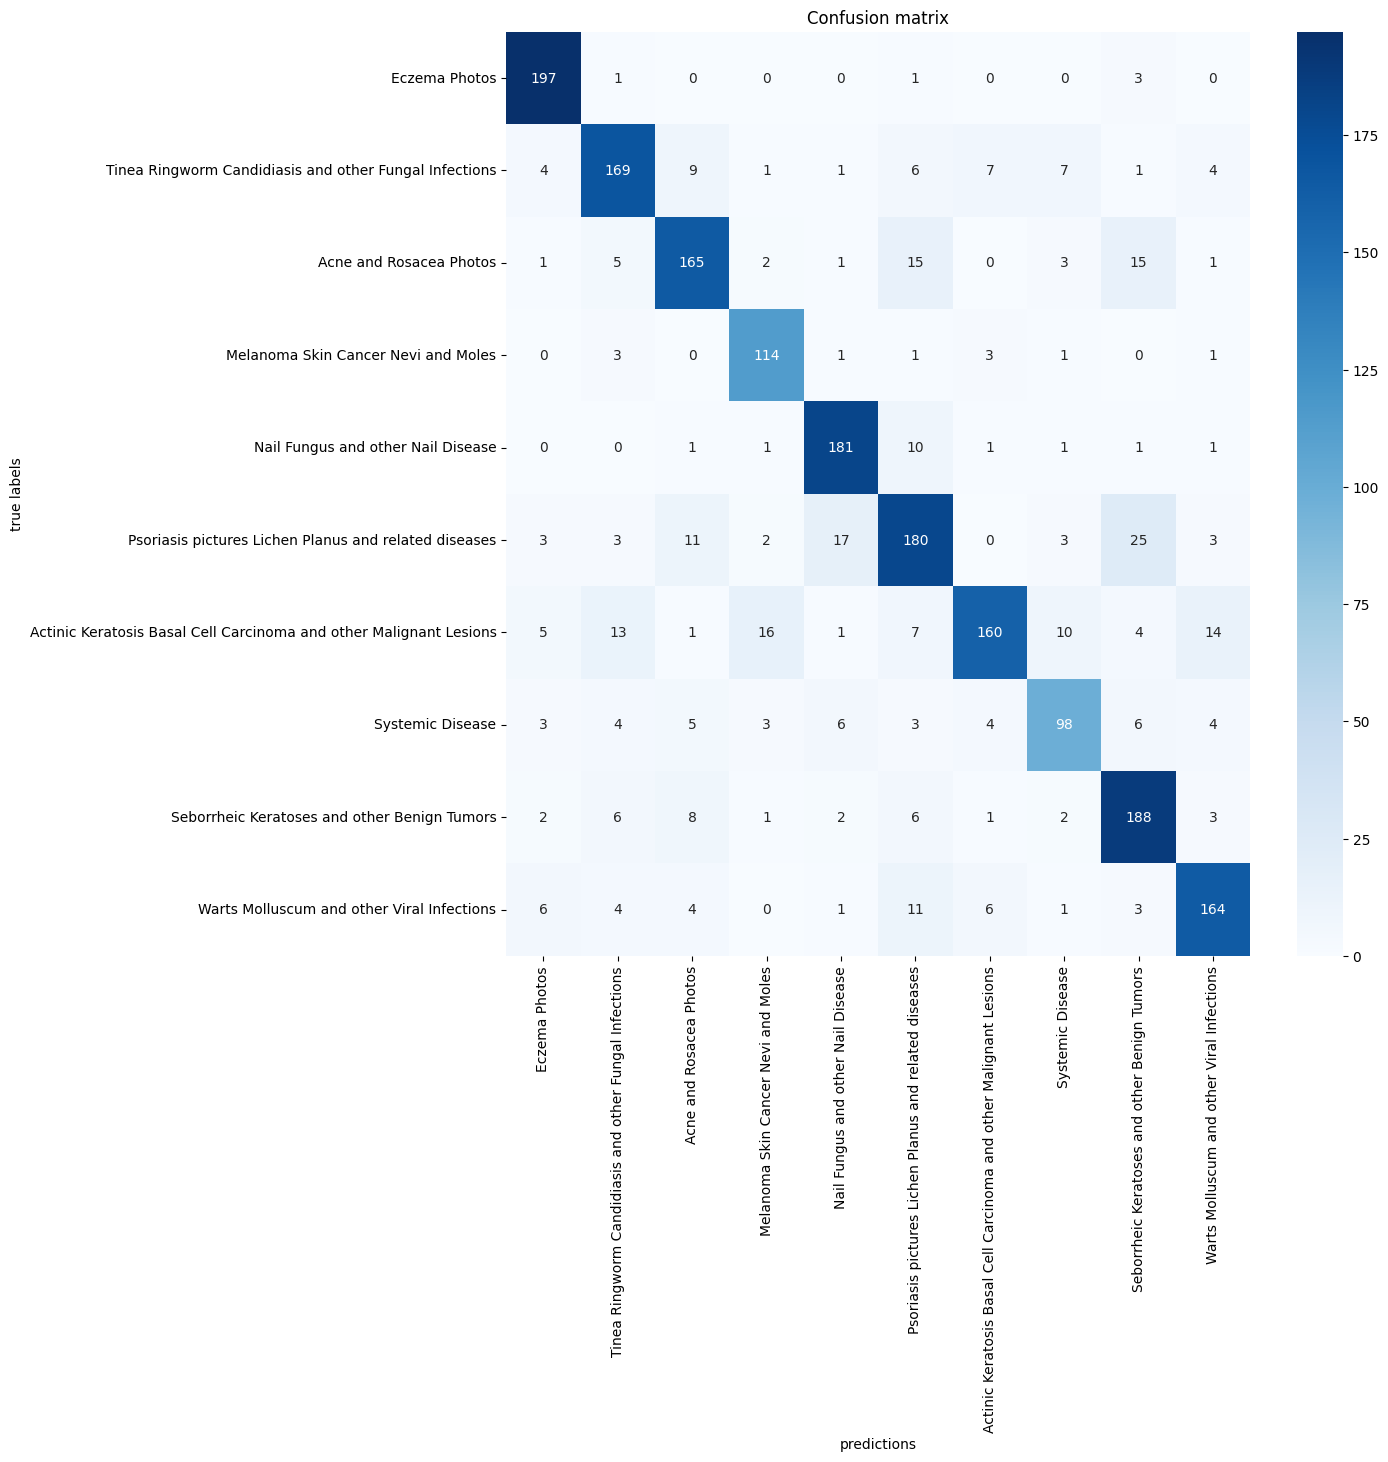

In [31]:
true_labels, predictions = test_model(model, dataloader_test, normalize=True)
c_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(12, 12))
plt.title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='g', cbar=True)
plt.xlabel('predictions')
plt.ylabel('true labels')
plt.show()

In [32]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [34]:
import torch



# Path to save the model
save_path = '/content/drive/MyDrive/resnet152.pt'

# Save the PyTorch model
torch.save(model.state_dict(), save_path)
